# EMNIST CNN Training Pipeline
This notebook trains a Convolutional Neural Network (CNN) on the EMNIST (Extended MNIST) dataset. Unlike standard MNIST which only contains digits, EMNIST contains both digits and handwritten letters.

Dataset Split: We use the 'balanced' split, which maps to 47 classes:
10 Digits (0-9)
26 Capital Letters (A-Z)
11 Lowercase Letters (a, b, d, e, f, g, h, n, q, r, t) - Note: Other lowercase letters are merged with uppercase because they look identical in handwriting (e.g., c, o, p, s).

In [9]:
#pip install tensorflow emnist matplotlib numpy

# Imports and Data Loading:

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from emnist import extract_training_samples, extract_test_samples
import numpy as np
import matplotlib.pyplot as plt

# 1. Load EMNIST 'balanced' dataset
# This might take a minute to download the first time
print("Downloading and loading EMNIST data...")
train_images, train_labels = extract_training_samples('balanced')
test_images, test_labels = extract_test_samples('balanced')

print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Unique classes: {len(np.unique(train_labels))}")

# 2. Define the Mapping (Class ID -> Character)
# This helps us visualize what we are training on
emnist_labels = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'
}

Training data shape: (112800, 28, 28)
Test data shape: (18800, 28, 28)
Unique classes: 47


# Data Preprocessing and Orientation Fix:

Critical Note: EMNIST images from the python library are often rotated and flipped compared to normal images. We fix this here.

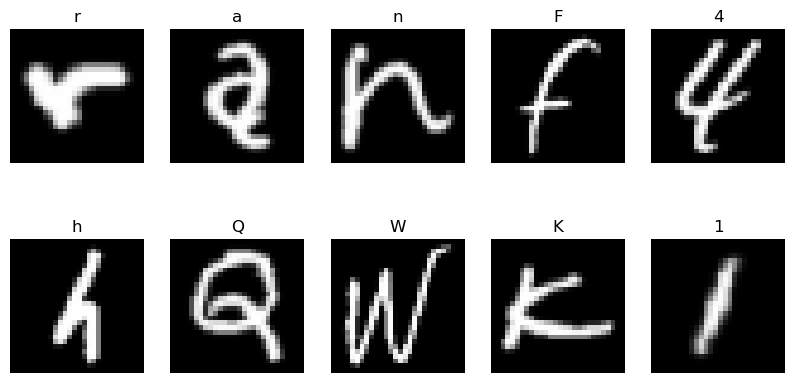

Data ready for training.


In [11]:
# 3. Data Preprocessing

# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Reshape for CNN input: (Height, Width, Channel) -> (28, 28, 1)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Visualize a few samples to check orientation
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    # If images look sideways/flipped, we might need np.transpose, but usually
    # the 'emnist' library handles extraction well. Let's verify visually.
    plt.imshow(train_images[i].reshape(28,28), cmap='gray')
    label_id = train_labels[i]
    plt.title(f"{emnist_labels[label_id]}")
    plt.axis('off')
plt.show()

# Categorical conversion is not strictly needed if we use 'sparse_categorical_crossentropy'
print("Data ready for training.")

# Model Architecture
We use a standard CNN architecture:
    1. Conv2D: Extracts features (edges, curves).
    2. MaxPooling: Reduces dimensionality.
    3. Dropout: Prevents overfitting (memorizing the data).
    4. Dense (Output): 47 neurons with Softmax activation for probability distribution.

In [12]:
# 4. Build the CNN Model
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third Convolutional Block (Optional but good for accuracy)
    layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)), # Might be too small to pool again
    
    layers.Flatten(),
    
    # Fully Connected Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Drops 50% of neurons randomly during training to improve generalization
    
    # Output Layer (47 classes for EMNIST Balanced)
    layers.Dense(47, activation='softmax')
])

model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\Talha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,319 (962.18 KB)

 Trainable params: 246,319 (962.18 KB)

 Non-trainable params: 0 (0.00 B)

# Training
We will train for about 5-10 epochs. Since the dataset is large, this should be sufficient to reach >85% accuracy.

In [13]:
# 5. Train the Model
history = model.fit(
    train_images, 
    train_labels, 
    epochs=200, 
    batch_size=64, 
    validation_split=0.1 # Use 10% of training data to validate during training
)

Epoch 1/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.6804 - loss: 1.0620 - val_accuracy: 0.8408 - val_loss: 0.4505
Epoch 2/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.8181 - loss: 0.5479 - val_accuracy: 0.8596 - val_loss: 0.3921
Epoch 3/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.8419 - loss: 0.4669 - val_accuracy: 0.8662 - val_loss: 0.3690
Epoch 4/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8540 - loss: 0.4236 - val_accuracy: 0.8712 - val_loss: 0.3523
Epoch 5/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8631 - loss: 0.3879 - val_accuracy: 0.8721 - val_loss: 0.3419
Epoch 6/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8688 - loss: 0.3678 - val_accuracy: 0.8722 - val_loss: 0.3434
Epoch 7/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8748 - loss: 0.3459 - val_accuracy: 0.8775 - val_loss: 0.3324
Epoch 8/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 

# Evaluation and Saving:

588/588 - 2s - 3ms/step - accuracy: 0.8702 - loss: 1.4145

Test accuracy: 87.02%


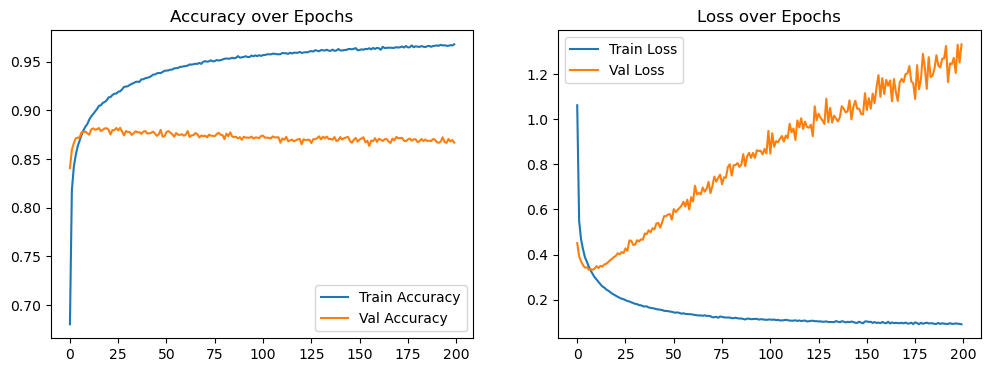

Model saved as 'emnist_model.h5'. You can now use this in the inference notebook.


In [ ]:
# 6. Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

# 7. Plot Training History
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

# 8. Save the Model
model.save('../models/emnist_model.h5')
print("Model saved as 'emnist_model.h5'. You can now use this in the inference notebook.")

# Test Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


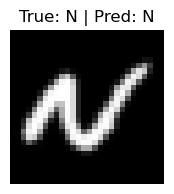

In [15]:
# 9. Test with a random image from the test set
import random

idx = random.randint(0, len(test_images))
img = test_images[idx]
true_label = test_labels[idx]

# Reshape for prediction (1, 28, 28, 1)
input_img = img.reshape(1, 28, 28, 1)

prediction = model.predict(input_img)
predicted_label = np.argmax(prediction)

plt.figure(figsize=(2, 2))
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.title(f"True: {emnist_labels[true_label]} | Pred: {emnist_labels[predicted_label]}")
plt.axis('off')
plt.show()

# Confusion Matrix and Classification Report

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


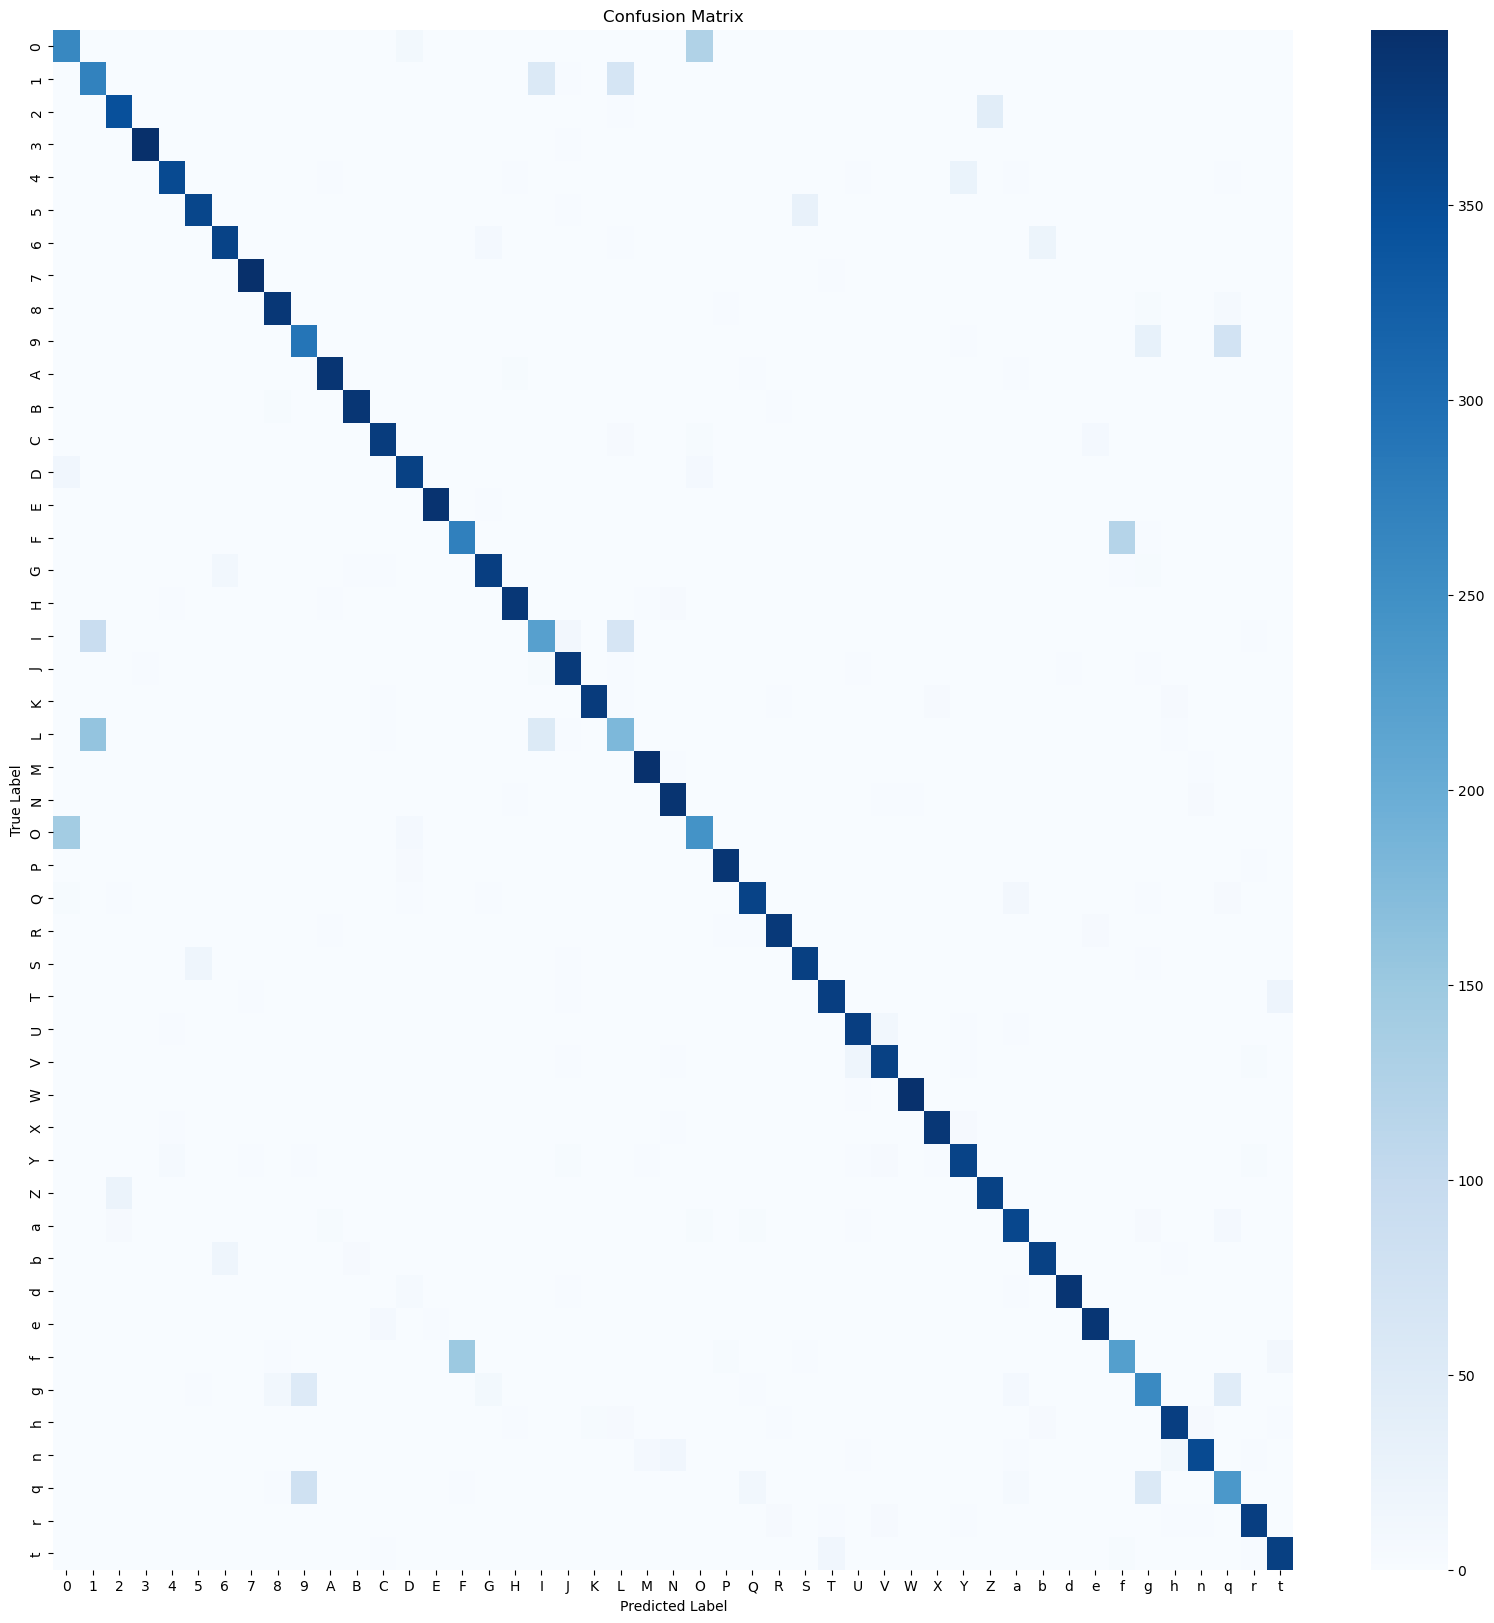


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.66      0.63       400
           1       0.52      0.68      0.59       400
           2       0.90      0.86      0.88       400
           3       0.99      0.99      0.99       400
           4       0.96      0.89      0.92       400
           5       0.95      0.91      0.92       400
           6       0.92      0.92      0.92       400
           7       0.97      0.98      0.98       400
           8       0.93      0.96      0.94       400
           9       0.68      0.72      0.70       400
           A       0.96      0.96      0.96       400
           B       0.96      0.96      0.96       400
           C       0.95      0.94      0.94       400
           D       0.91      0.92      0.92       400
           E       0.98      0.97      0.98       400
           F       0.63      0.69      0.66       400
           G       0.92      0.93      0.93       400
   

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get detailed predictions for the entire test set
y_pred_probs = model.predict(test_images)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Create Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_classes)

# Plot Heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=[emnist_labels[i] for i in range(47)],
            yticklabels=[emnist_labels[i] for i in range(47)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_classes, 
                            target_names=[emnist_labels[i] for i in range(47)]))